In [1]:
contract = 'RI'
#figsize(13, 8)

import pyquant
import pylab
import pandas
import numpy
import scipy
from pyquant.transforms import ADX
ohlc = pyquant.prep_data_finam(update=0).sort_index()

ModuleNotFoundError: No module named 'ma'

### London

#### Описание стратегии
Если в 11-00 (открытие лондона) относительно цены на 20-30 предыдущего дня (закрытие лондона вчера) цена выросла/упала на X пунктов (разный уровень для лонга и шорта) то входим в контртренд с выходом в 16-00.


Trade freq:  12.4545/month
Profit:      103955.0
Points:      685
Average:     151.7591
  Gain:      1546.0465
  Loss:      -1254.7947
Winrate:     0.5022
Payoff:      1.2321
PF:          1.243
RF:          3.8353
Sharpe:      0.0638
Sortino:     0.1255
0.99 WCDD:   63269.0
UPI:         0.0198



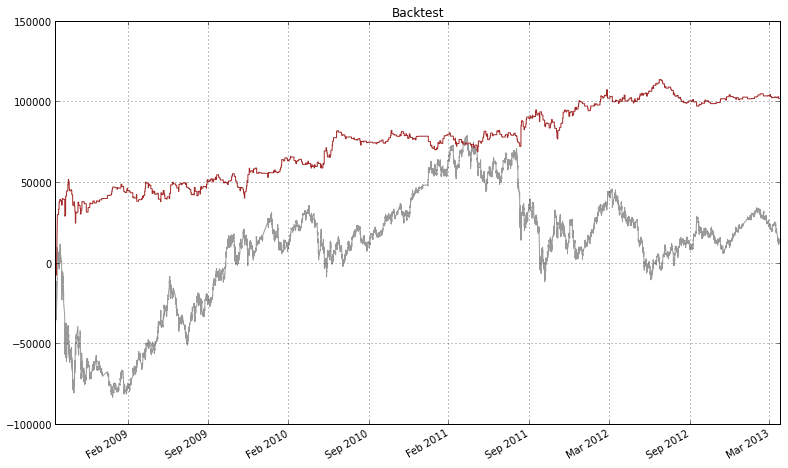

In [2]:
def runbt(buy_level=1000, short_level=666, set_globals=False):
    
    bars = ohlc.tz_localize('Europe/Moscow')
    utcbars = bars.tz_convert('UTC')
    c = bars.C
    
    Lc = utcbars.C.at_time('16:30').reindex(utcbars.index, method='ffill')
    Lo = utcbars.O.at_time('8:00').reindex(utcbars.index, method='ffill')
    sig = (Lo - Lc).at_time('8:00').tz_convert('Europe/Moscow')

    buy = sig < -buy_level
    short = sig > short_level
    cover = sell = ohlc.C.at_time('16:00').astype(bool).tz_localize\
        ('Europe/Moscow')
    
    buyprice = shortprice = bars.O
    sellprice = coverprice = bars.C
    
    if set_globals:
        globals().update(locals())
    
    return pyquant.Backtest(locals(), set_globals=set_globals)


eq = runbt(set_globals=True)
eq.summary()
eq.plot_equity()

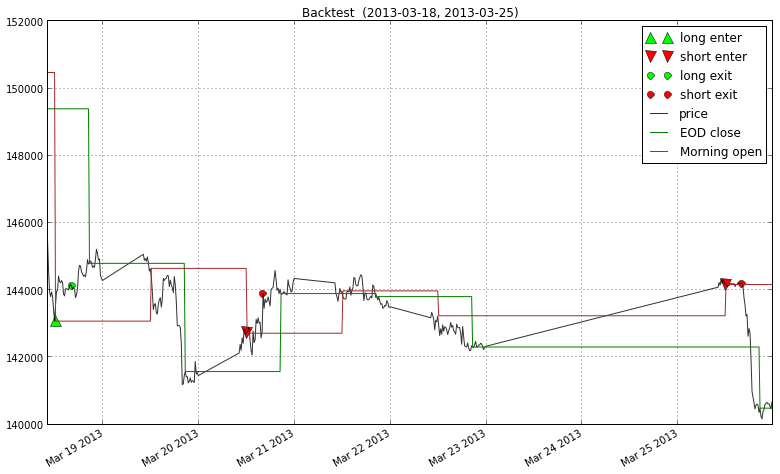

In [3]:
s = slice('2013-03-18', '2013-03-25')
eq.sigplot[s]
Lc[s].plot(color='green', label='EOD close')
Lo[s].plot(color='brown', label='Morning open')
pylab.legend()

Optimization code

In [4]:
do_opt = False


if do_opt:
    
    def upi_cost(params):
        eq = runbt(*params, set_globals=False).equity
        upi = pyquant.equity.performance.UPI(eq)
        if upi < 0:
            return numpy.inf
        cost = 1. / upi
        print params, cost
        return cost
    def pnl_cost(params):
        eq = runbt(*params).equity
        pnl = eq.sum()
        if pnl < 0:
            return numpy.inf
        cost = 1. / pnl
        print params, cost
        return cost
    
    from scipy.optimize import brute
    x = brute(pnl_cost, [(50, 1000, 50), (50, 1000, 50)], full_output=True)
    print x
    params, score, grid, fgrid = x
    pyquant.plot.show_grid(grid)